In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt

def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))
        else:
            merged.append(current)
    return merged

def generate_dynamic_availability(total_time_steps, worker_id, num_workers, max_periods=5, min_processing_time=2):
    # On définit le centre de la simulation
    center = total_time_steps / 2
    # On fixe un offset maximum (par exemple total_time_steps / 8)
    max_offset = total_time_steps / 8
    # Calcul de l'offset pour chaque worker de façon symétrique
    if num_workers % 2 == 1:
        mid = (num_workers + 1) / 2
        offset = ((worker_id - mid) / mid) * max_offset
    else:
        mid = num_workers / 2
        offset = ((worker_id - mid - 0.5) / mid) * max_offset
    base_mean = center + offset
    # On ajoute un petit aléa pour éviter une régularité trop marquée
    mean = int(np.clip(base_mean + random.randint(-total_time_steps // 20, total_time_steps // 20), 0, total_time_steps - min_processing_time))
    std_dev = total_time_steps / 6
    availability_periods = []
    num_periods = random.randint(1, max_periods)
    for _ in range(num_periods):
        start_time = int(np.clip(np.random.normal(mean, std_dev), 0, total_time_steps - min_processing_time))
        duration = max(min_processing_time, int(np.abs(np.random.normal(3, 2))))
        end_time = min(start_time + duration, total_time_steps)
        if end_time - start_time >= min_processing_time:
            availability_periods.append((start_time, end_time))
    return merge_intervals(availability_periods)


# Définition du modèle de réseau de neurones
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Gestionnaire de mini-batches avec SubsetRandomSampler
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)
        self.sampler = SubsetRandomSampler(self.indices)
        self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            random.shuffle(self.indices)
            self.sampler = SubsetRandomSampler(self.indices)
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# ------------------------------------------------------------------------------
# Classe Worker : gère le calcul local des gradients
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_id = None

    def is_available(self, current_time):
        for start_time, end_time in self.availability_periods:
            if start_time <= current_time < end_time:
                if self.finish_time is None or current_time >= self.finish_time:
                    return (current_time + self.processing_time) <= end_time
        return False

    def start_computation(self, current_time, batch_id, data, targets):
        if self.current_batch_id is None or self.current_batch_id != batch_id:
            self.current_batch_id = batch_id
            self.finish_time = current_time + self.processing_time
            #print(f"🚀 [T={current_time}] Worker {self.worker_id} commence un NOUVEAU calcul sur batch {batch_id}.")
            return self.compute_gradient(data, targets)
        return None

    def has_finished(self, current_time):
        return self.finish_time == current_time

    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}
        return gradients, self.current_batch_id
    def update_model(self, model_state_dict):
        self.model.load_state_dict(model_state_dict)

# ------------------------------------------------------------------------------
# Serveur central : gère l'application des gradients
class Server:
    def __init__(self, dataset, batch_size=64, lr=0.001, max_contribution_ratio=0.5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SimpleNN().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.current_batch = None
        self.current_batch_id = 0
        self.model_updated = True
        self.worker_contributions = {}   # Nombre de contributions utiles par worker
        self.wasted_gradients = {}       # Temps perdu par worker (en unités de temps discret)
        self.batch_send_times = {}       # Enregistre le temps d'envoi de chaque batch
        self.total_wasted_time = 0       # Temps total de computing perdu
        self.max_contribution_ratio = max_contribution_ratio  # Seuil maximal de contribution par worker

    def update_global_model(self, worker_gradients, batch_id, worker_id, current_time):
        # Calculer la contribution totale actuelle (si non nul)
        total_contrib = sum(self.worker_contributions.values()) if self.worker_contributions else 0
        
        # Appliquer le contrôle du ratio uniquement si le seuil est inférieur à 1
        if self.max_contribution_ratio < 1 and total_contrib > 0:
            worker_ratio = self.worker_contributions.get(worker_id, 0) / total_contrib
            if worker_ratio >= self.max_contribution_ratio:
                send_time = self.batch_send_times.get(batch_id, current_time)
                wasted = current_time - send_time
                self.wasted_gradients[worker_id] = self.wasted_gradients.get(worker_id, 0) + wasted
                self.total_wasted_time += wasted
                return

        if worker_gradients is None or batch_id != self.current_batch_id:
            send_time = self.batch_send_times.get(batch_id, current_time)
            wasted = current_time - send_time
            self.wasted_gradients[worker_id] = self.wasted_gradients.get(worker_id, 0) + wasted
            self.total_wasted_time += wasted
            return

        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = worker_gradients[name]
        self.optimizer.step()
        self.worker_contributions[worker_id] = self.worker_contributions.get(worker_id, 0) + 1
        self.model_updated = True


    def compute_wasted_computing_time(self):
        return self.total_wasted_time

    def print_worker_statistics(self):
        print("\n Résumé des contributions utiles des workers :")
        sorted_contrib = sorted(self.worker_contributions.items(), key=lambda x: x[1], reverse=True)
        for worker_id, count in sorted_contrib:
            print(f"🔹 Worker {worker_id} a contribué {count} fois à la mise à jour du modèle.")
        print("\n Résumé des wasted computing (temps perdu) :")
        sorted_wasted = sorted(self.wasted_gradients.items(), key=lambda x: x[1], reverse=True)
        for worker_id, wasted_time in sorted_wasted:
            print(f"🔹 Worker {worker_id} a perdu {wasted_time} unités de temps de computing.")
        wasted_time_total = self.compute_wasted_computing_time()
        print(f"\n Temps total de computing perdu : {wasted_time_total} unités de temps.")

    def get_batch_for_worker(self, current_time):
        if self.model_updated:
            self.current_batch = self.batch_manager.get_next_batch()
            self.current_batch_id += 1
            self.batch_send_times[self.current_batch_id] = current_time
            self.model_updated = False
        return self.current_batch, self.current_batch_id

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        return 100 * correct / total

    def plot_wasted_computing(self):
        """Affiche un histogramme des unités de temps de computing perdues par worker."""
        if not self.wasted_gradients:
            return

        worker_ids = list(self.wasted_gradients.keys())
        wasted_times = list(self.wasted_gradients.values())

        plt.figure(figsize=(10, 6))
        plt.bar(worker_ids, wasted_times, color='red', alpha=0.7)
        plt.xlabel("ID du Worker")
        plt.ylabel("Unités de Temps de Computing Perdues")
        plt.title("Histogramme des Computing Perdus par Worker")

        plt.xticks(worker_ids)

        # Ajustement automatique des ticks de Y
        plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=6, integer=True))

        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()


#### Simulation d'apprentissage fédéré avec affichage des statistiques et disponibilités
class DiscreteEventSimulator:
    def __init__(self, server, workers, test_loader, total_time_steps=100):
        self.server = server
        self.workers = workers
        self.test_loader = test_loader
        self.total_time_steps = total_time_steps
        self.global_time = 0
        self.worker_computing = []
        
    def plot_worker_availability(self):
        num_workers = len(self.workers)
        total_time_steps = self.total_time_steps
        availability_data = [(worker.worker_id, worker.availability_periods) for worker in self.workers]
        time_grid = np.zeros((num_workers, total_time_steps))
        for worker_id, periods in availability_data:
            for start, end in periods:
                time_grid[worker_id - 1, start:end] = 1
        plt.figure(figsize=(12, 6))
        plt.imshow(np.flipud(time_grid), aspect="auto", cmap="Blues", interpolation="nearest")
        plt.xlabel("Temps (Steps)")
        plt.ylabel("Workers")
        plt.title("Disponibilité des Travailleurs avant la Simulation")

        # Ajustement des ticks pour correspondre aux workers réels
        plt.xticks(range(0, total_time_steps, max(1, total_time_steps // 10)))
        plt.yticks(range(num_workers), [f"Worker {i}" for i in reversed(range(1, num_workers + 1))])

        plt.colorbar(label="Disponibilité (1 = Disponible, 0 = Indisponible)")
        plt.show()

        availability_counts = np.sum(time_grid, axis=0)
        mean_time = total_time_steps / 2
        std_dev_time = total_time_steps / 6
        x = np.arange(total_time_steps)
        normal_distribution = num_workers * (1 / (std_dev_time * np.sqrt(2 * np.pi))) * \
                              np.exp(-((x - mean_time) ** 2) / (2 * std_dev_time ** 2))
        plt.figure(figsize=(12, 6))
        plt.plot(x, availability_counts, marker='o', linestyle='-', label="Disponibilité totale réelle", color='blue')
        plt.plot(x, normal_distribution, linestyle='--', label="Approximation Normale", color='red')
        plt.xlabel("Temps (Steps)")
        plt.ylabel("Nombre de Travailleurs Disponibles")
        plt.title("Comparaison de la Disponibilité des Travailleurs avec une Loi Normale")
        plt.legend()
        plt.grid()
        plt.show()

    def run(self):
        #print(" Affichage des disponibilités des workers avant la simulation...")
        #self.plot_worker_availability()
        #print(" Démarrage de la simulation...")
        for worker in self.workers:
            #print(f" Worker {worker.worker_id} disponible aux périodes {worker.availability_periods} | Temps de traitement : {worker.processing_time}")
            pass
        while self.global_time < self.total_time_steps:
            #print(f"\n Temps {self.global_time}")
            newly_finished_workers = [worker for worker in self.worker_computing if worker.has_finished(self.global_time)]
            for worker in newly_finished_workers:
                self.worker_computing.remove(worker)
                batch, _ = self.server.get_batch_for_worker(self.global_time)
                data, targets = batch
                gradients, batch_id = worker.compute_gradient(data, targets)
                self.server.update_global_model(gradients, batch_id, worker.worker_id, self.global_time)
            available_workers = [worker for worker in self.workers if worker.is_available(self.global_time) and worker not in self.worker_computing]
            for worker in available_workers:
                batch, batch_id = self.server.get_batch_for_worker(self.global_time)
                data, targets = batch
                worker.start_computation(self.global_time, batch_id, data, targets)
                self.worker_computing.append(worker)
            if self.global_time % 5 == 0:
                accuracy = self.server.evaluate(self.test_loader)
                #print(f" [T={self.global_time}] Précision du modèle: {accuracy:.2f}%")
            self.global_time += 1
        print(" Simulation terminée !")
        #self.server.print_worker_statistics()
        #self.server.plot_wasted_computing()



In [4]:
class ByzantineWorker(Worker):
    def compute_gradient(self, data, targets):
        #print(f"⚠️ [Byzantin] Worker {self.worker_id} envoie un gradient corrompu !")
        corrupted_gradients = {name: torch.full_like(param, 1e10) for name, param in self.model.named_parameters()}
        return corrupted_gradients, self.current_batch_id

## librairie

BIZFL

In [5]:
### Chargement des données
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # Initialisation du serveur et des workers
# server = Server(train_dataset)
# workers = []
# num_workers = 10
# total_time_steps = 51  
# byzantine_percentage = 20  # Pourcentage de travailleurs byzantins
# num_byzantine = int((byzantine_percentage / 100) * num_workers)

# workers = []
# for i in range(num_workers):
#     processing_time = random.randint(2, 4)
#     availability = generate_dynamic_availability(total_time_steps, i, num_workers, max_periods=5, min_processing_time=processing_time)
    
#     if i < num_byzantine:
#         workers.append(ByzantineWorker(server.model, server.device, i, availability, processing_time))
#     else:
#         workers.append(Worker(server.model, server.device, i, availability, processing_time))


# simulator = DiscreteEventSimulator(server, workers, test_loader, total_time_steps=total_time_steps)
# simulator.run()


 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation terminée !
 Simulation

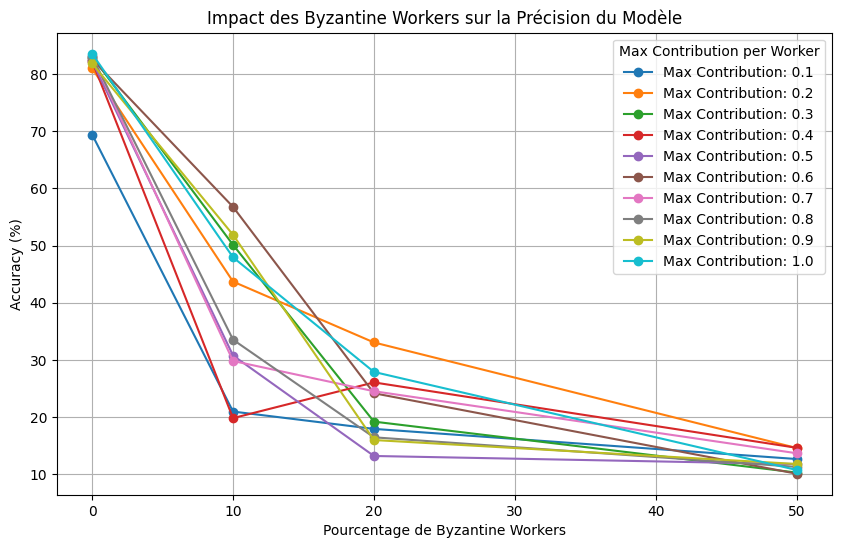

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Liste des pourcentages de workers byzantins à tester
byzantine_percentages = [0, 10, 20, 50]
max_contribution_per_worker_values = np.arange(0.1, 1.1 , 0.1)
num_runs = 10  # Nombre de runs pour chaque configuration

# Paramètres fixes
num_workers = 10
total_time_steps = 288  # 1 step is 5 min

# Stockage des résultats
results = {}

for max_contribution_per_worker in max_contribution_per_worker_values:
    mean_accuracies = []

    for byzantine_percentage in byzantine_percentages:
        accuracies = []

        for run in range(num_runs):
            # Création du serveur avec la contribution max en paramètre
            server = Server(train_dataset, max_contribution_ratio=max_contribution_per_worker)
            workers = []
            num_byzantine = int((byzantine_percentage / 100) * num_workers)

            for i in range(num_workers):
                processing_time = random.randint(2, 4)
                availability = generate_dynamic_availability(total_time_steps, i, num_workers, max_periods=5, min_processing_time=processing_time)

                if i < num_byzantine:
                    workers.append(ByzantineWorker(server.model, server.device, i, availability, processing_time))
                else:
                    workers.append(Worker(server.model, server.device, i, availability, processing_time))

            # Lancer la simulation
            simulator = DiscreteEventSimulator(server, workers, test_loader, total_time_steps=total_time_steps)
            simulator.run()

            # Stocker l'accuracy finale
            final_accuracy = server.evaluate(test_loader)
            accuracies.append(final_accuracy)

        # Calcul de la moyenne et stockage
        mean_acc = np.mean(accuracies)
        mean_accuracies.append(mean_acc)

    results[max_contribution_per_worker] = mean_accuracies

# 📈 Tracer le graphique avec les moyennes pour chaque max_contribution_per_worker
plt.figure(figsize=(10, 6))

for max_contribution_per_worker, accuracies in results.items():
    plt.plot(byzantine_percentages, accuracies, marker='o', linestyle='-', label=f"Max Contribution: {max_contribution_per_worker:.1f}")

plt.xlabel("Pourcentage de Byzantine Workers")
plt.ylabel("Accuracy (%)")
plt.title("Impact des Byzantine Workers sur la Précision du Modèle")
plt.legend(title="Max Contribution per Worker")
plt.grid(True)

# Sauvegarde du graphique
plt.savefig("impact_byzantine_workers.pdf")
plt.show()
